## Protein-Protein Binding Affinity Prediction using Random Forest Regressor

##### Beryl Ramadhian Aribowo 
##### DDP - Master, Kanazawa University

https://github.com/berylgithub

### Feature Extraction

The data is pre-processed to acquire the $D=\{(y^{(n)}, \vec{x}^{(n)})\}^N_{n=1}$ array. By calculating the Heaviside step function that counts the contacts of atoms between proteins ($d_{cutoff}$) within 12 Angstrom. The formula to count the number of occurence between $j$ and $i$ atom is as follows:
<br>
$x_{Z(P_X(j)),Z(P_Y(i))}\equiv\sum^{K_j}_{k=1}\sum^{L_i}_{l=1} \odot (d_{cutoff} - d_{kl})$
<br>

Here $P_X(j)$ corresponds to the protein atoms within the first chain of the protein pairing combination, and $P_Y(i)$ corresponds to the protein atoms within the second one, where four atom types are considered respectively as follows:
<br>
$\{P_N(j)\}_{j=1}^{4} = \{C,N,O,S\}$, $N \in Z^+$,<br>
The hydrophobic patches and acid patches interactions respectively are also considered: 
<br>
- hydrophobic patch : $\{C\alpha_H\}$
<br>
- acid patch : $\{C\alpha_A\}$,
<br>

where $C\alpha_H$ and $C\alpha_A$ is the total interactions between carbon-alpha on Hydrophobic and Acid patch respectively.

Therefore the total atomic interaction features used are $|\{P_N(j)\}_{j=1}^{4}|^2 + |\{C\alpha_H\}| + |\{C\alpha_A\}| = 18$

Suppose there are four chains of protein $S = \{P_1, P_2, P_3, P_4 \}$, the interaction is the combinations of two chains, hence the total of interactions between two chains for this case is $c^{|S|}_2$=6 (where $c$ here refers to combination formula), the list of chains combination are as follows:
<br>
$\sum interaction = interaction(P_1, P_2) + interaction(P_1,P_3) + interaction(P_1,P_4) + interaction(P_2,P_3) + interaction(P_2,P_4) + interaction(P_3,P_4)$

The script used for data preprocessing and feature extraction is available at https://github.com/berylgithub/ppbap.

### Data and Model loading

In [60]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from scipy.stats import pearsonr
from math import sqrt

import pickle
import os

### First type model: 16 features ([C, N, O, S] interactions)

In [61]:
'''Dataset Loader'''
def dataset_loader(filepath):
    data = []
    try:
        with open(filepath, 'rb') as fr:
            try:
                while True:
                    data.append(pickle.load(fr))
            except EOFError:
                pass            
    except FileNotFoundError:
        print('File is not found')
    saved_ids = [d['id'] for d in data]
    return data

standard_data_file = os.getcwd()+'/Data/dataset_alpha_12A.pkl'
combined_ha_data_file = os.getcwd()+'/Data/dataset_ha_beta_12A.pkl'
dataset = dataset_loader(standard_data_file)

features = np.array([data['x_vector'] for data in dataset])
labels = np.array([data['y'] for data in dataset])
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=13)
print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (1812, 16)
Training Labels Shape: (1812,)
Testing Features Shape: (604, 16)
Testing Labels Shape: (604,)


In [62]:
'''Model Loader'''
standard_model_file= os.getcwd()+"/Model/rf_pp_alpha_12A_split.pkl"
combined_ha_model_file= os.getcwd()+"/Model/rf_pp_ha_beta_12A_split.pkl"
with open(standard_model_file, "rb") as f:
    rf = pickle.load(f)

C:\Users\beryl\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\beryl\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [63]:
'''Model evaluation on training set'''
#Mean Absolute Error
preds = rf.predict(x_train)
errors = abs(preds - y_train)
print('Mean Absolute Error:', round(np.mean(errors), 2))

#Mean Absolute Percentage Error & Accuracy
mape = 100 * (errors / y_train)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

#Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_train, preds))
print('Root Mean Squared Error :', round(rmse, 2))

#Pearson Correlation Coefficient (PCC) score
pcc = pearsonr(y_train, preds)
print('Pearson Correlation Coefficient :', round(pcc[0],2))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished


Mean Absolute Error: 0.52
Accuracy: 91.89 %.
Root Mean Squared Error : 0.66
Pearson Correlation Coefficient : 0.98


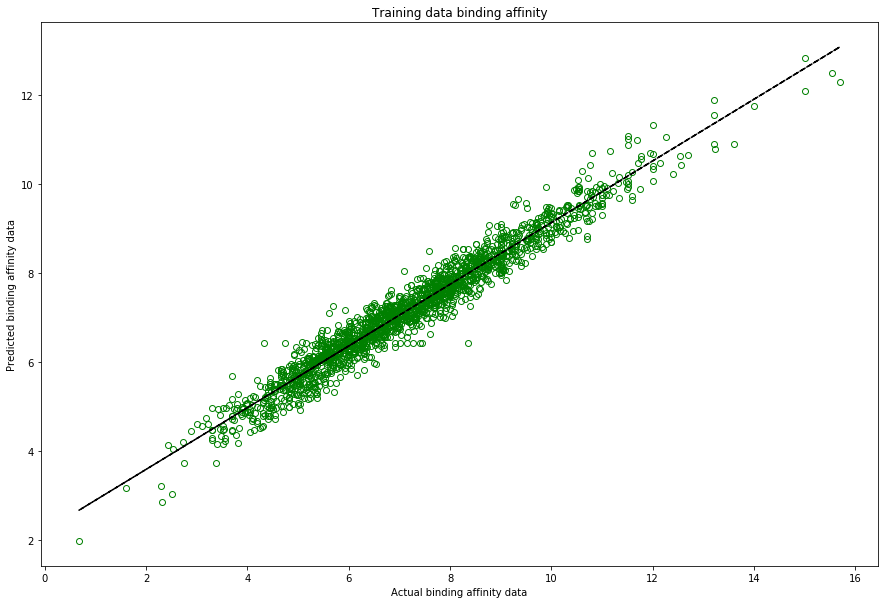

In [64]:
'''Visualization on training set'''
import matplotlib.pyplot as plt

fig_size = np.zeros(2)
fig_size[0] = 15
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

f, ax = plt.subplots()

plt.plot(y_train, preds, 'o', markerfacecolor="None", markeredgecolor='green', markeredgewidth=1)
#ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
coef = np.polyfit(y_train,preds,1)
poly1d_fn = np.poly1d(coef)
plt.plot(y_train, poly1d_fn(y_train), '--k')

plt.title("Training data binding affinity")
plt.xlabel('Actual binding affinity data')
plt.ylabel('Predicted binding affinity data')
#plt.legend()
plt.show()

In [65]:
'''Model evaluation on Test set'''
#Mean Absolute Error
preds = rf.predict(x_test)
errors = abs(preds - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2))

#Mean Absolute Percentage Error & Accuracy
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

#Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, preds))
print('Root Mean Squared Error :', round(rmse, 2))

#Pearson Correlation Coefficient (PCC) score
pcc = pearsonr(y_test, preds)
print('Pearson Correlation Coefficient :', round(pcc[0],2))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished


Mean Absolute Error: 1.47
Accuracy: 76.67 %.
Root Mean Squared Error : 1.87
Pearson Correlation Coefficient : 0.35


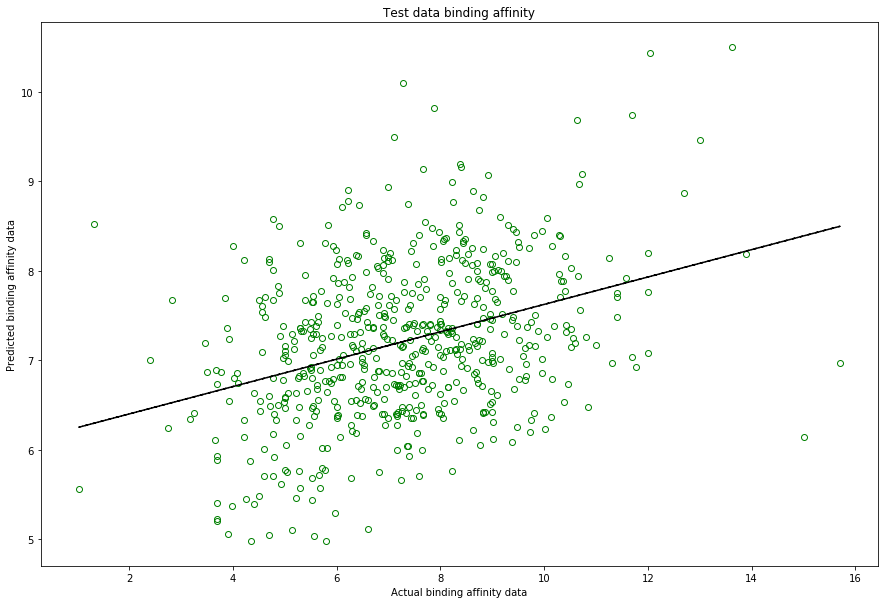

In [66]:
'''Visualization on test set'''
import matplotlib.pyplot as plt

fig_size = np.zeros(2)
fig_size[0] = 15
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

f, ax = plt.subplots()

plt.plot(y_test, preds, 'o', markerfacecolor="None", markeredgecolor='green', markeredgewidth=1)
#ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
coef = np.polyfit(y_test,preds,1)
poly1d_fn = np.poly1d(coef)
plt.plot(y_test, poly1d_fn(y_test), '--k')


plt.title("Test data binding affinity")
plt.xlabel('Actual binding affinity data')
plt.ylabel('Predicted binding affinity data')
#plt.legend()
plt.show()


Top Feature ranking:
1. feature 10 (0.083682)
2. feature 13 (0.077048)
3. feature 0 (0.073376)
4. feature 8 (0.069573)
5. feature 12 (0.066819)
6. feature 9 (0.063811)
7. feature 7 (0.063336)
8. feature 3 (0.063243)
9. feature 2 (0.060709)
10. feature 14 (0.059633)
11. feature 6 (0.058835)
12. feature 4 (0.058746)
13. feature 5 (0.054110)
14. feature 11 (0.050171)
15. feature 1 (0.049238)
16. feature 15 (0.047671)


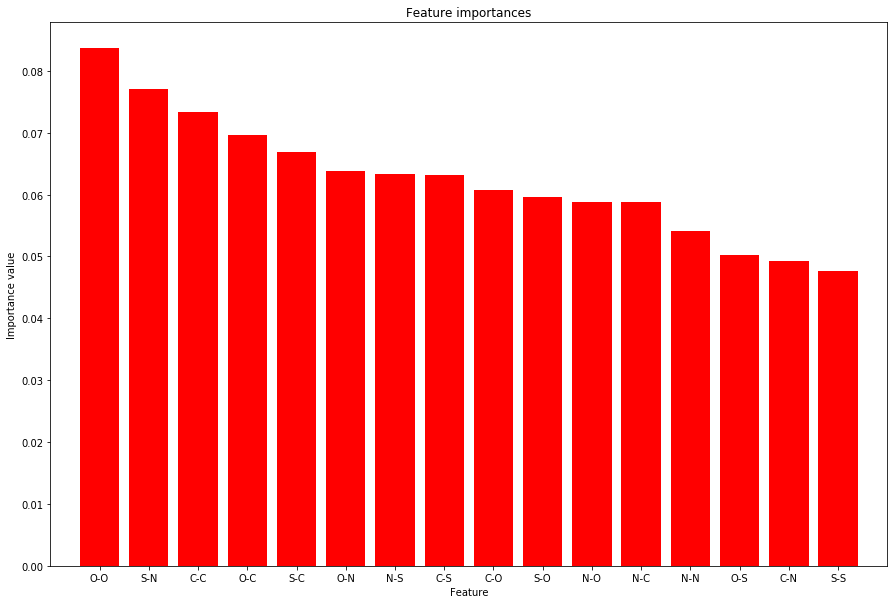

In [67]:
'''
features based on combination of:
atom_types = ['C','N','O,'S']
'''

atom_types = ['C','N','O','S']
feature_labels = []
for i in range(len(atom_types)):
    for j in range(len(atom_types)):
        label = atom_types[i]+'-'+atom_types[j]
        feature_labels.append(label)
feature_labels+=['C_a_H', 'C_a_A']
feature_labels=np.array(feature_labels)

importance = rf.feature_importances_

#indices = np.argsort(importance)[::-1][:20]
indices = np.argsort(importance)[::-1]

print("Top Feature ranking:")
n = importance.shape[0]
#n = 20
for f in range(n):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importance[indices[f]]))

plt.figure()
plt.title("Feature importances")
plt.bar(range(n), importance[indices],
       color="r", align="center")
plt.xticks(range(n), feature_labels[indices])
plt.xlim([-1, n])
plt.xlabel('Feature')
plt.ylabel('Importance value')
plt.show()

In [14]:
'''
permutation importance on train data
'''
result = permutation_importance(rf, x_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=-1)

sorted_idx = result.importances_mean.argsort()
p_importance_mean_train = result.importances_mean
print(p_importance_mean_train)
print(sorted_idx)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished


[0.177196   0.07633217 0.1437247  0.14160894 0.11939359 0.09745755
 0.11119658 0.21882789 0.162793   0.13234326 0.24534185 0.0835425
 0.13751559 0.36592612 0.12178895 0.17602715]
[ 1 11  5  6  4 14  9 12  3  2  8 15  0  7 10 13]


In [15]:
'''
permutation importance on test data
'''
result = permutation_importance(rf, x_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=-1)

sorted_idx = result.importances_mean.argsort()
p_importance_mean_test = result.importances_mean
print(p_importance_mean_test)
print(sorted_idx)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished


[ 0.02792791  0.00629706  0.01001     0.01219087 -0.00475826 -0.00480654
  0.00537015  0.02179903  0.0247389   0.01759114  0.04163343 -0.00385844
  0.00853628  0.07242679 -0.00254297  0.06047654]
[ 5  4 11 14  6  1 12  2  3  9  7  8  0 10 15 13]


In [22]:
print(np.sum(p_importance_mean_train), np.sum(p_importance_mean_test))

2.5110158454401885 0.293031901471745


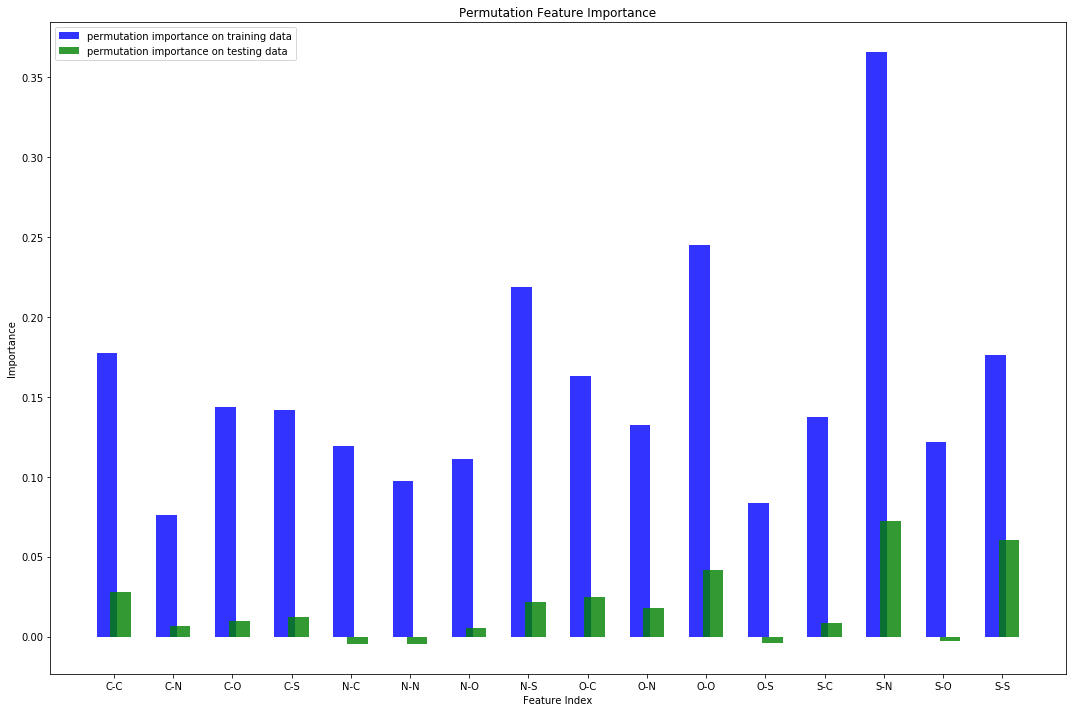

In [30]:
# data to plot
length = len(p_importance_mean_test)


# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index - bar_width/3, p_importance_mean_train, bar_width,
alpha=opacity,
color='b',
label='permutation importance on training data')

rects2 = plt.bar(index + bar_width/3, p_importance_mean_test, bar_width,
alpha=opacity,
color='g',
label='permutation importance on testing data')

plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Permutation Feature Importance')
plt.xticks(np.arange(0,length), feature_labels)
plt.legend()

plt.tight_layout()
plt.show()

### Second type model: 18 features ([C, N, O, S] + CA_H + CA_A)

#### 12 Angstrom cutoff

In [68]:
data_file = os.getcwd()+'/Data/dataset_ha_beta_12A.pkl'
dataset = dataset_loader(data_file)

features = np.array([data['x_vector'] for data in dataset])
labels = np.array([data['y'] for data in dataset])
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=13)
print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (1812, 18)
Training Labels Shape: (1812,)
Testing Features Shape: (604, 18)
Testing Labels Shape: (604,)


In [69]:
'''Model Loader'''
model_file= os.getcwd()+"/Model/rf_pp_ha_beta_12A_split.pkl"
with open(model_file, "rb") as f:
    rf = pickle.load(f)

C:\Users\beryl\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\beryl\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [70]:
'''Model evaluation on Test set'''
#Mean Absolute Error
preds = rf.predict(x_test)
errors = abs(preds - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2))

#Mean Absolute Percentage Error & Accuracy
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

#Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, preds))
print('Root Mean Squared Error :', round(rmse, 2))

#Pearson Correlation Coefficient (PCC) score
pcc = pearsonr(y_test, preds)
print('Pearson Correlation Coefficient :', round(pcc[0],2))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished


Mean Absolute Error: 1.41
Accuracy: 77.63 %.
Root Mean Squared Error : 1.8
Pearson Correlation Coefficient : 0.43


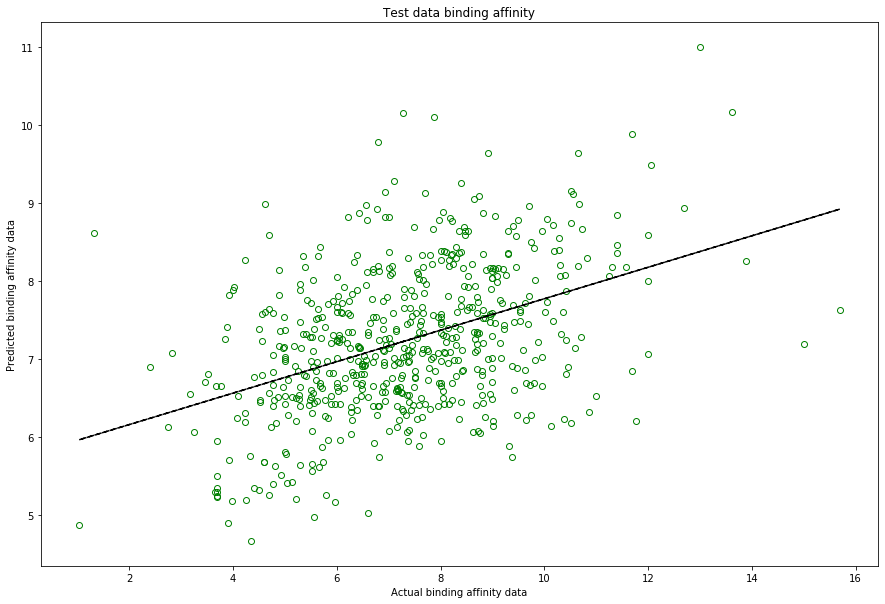

In [71]:
import matplotlib.pyplot as plt

fig_size = np.zeros(2)
fig_size[0] = 15
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

f, ax = plt.subplots()

plt.plot(y_test, preds, 'o', markerfacecolor="None", markeredgecolor='green', markeredgewidth=1)
#ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
coef = np.polyfit(y_test,preds,1)
poly1d_fn = np.poly1d(coef)
plt.plot(y_test, poly1d_fn(y_test), '--k')

plt.title("Test data binding affinity")
plt.xlabel('Actual binding affinity data')
plt.ylabel('Predicted binding affinity data')
#plt.legend()
plt.show()

Top Feature ranking:
1. feature 17 (0.108756)
2. feature 16 (0.101709)
3. feature 10 (0.075521)
4. feature 8 (0.060101)
5. feature 9 (0.059726)
6. feature 0 (0.056625)
7. feature 13 (0.053568)
8. feature 6 (0.049845)
9. feature 4 (0.049822)
10. feature 2 (0.049602)
11. feature 12 (0.047659)
12. feature 5 (0.043194)
13. feature 1 (0.043105)
14. feature 7 (0.043006)
15. feature 14 (0.042519)
16. feature 3 (0.041040)
17. feature 11 (0.040243)
18. feature 15 (0.033961)


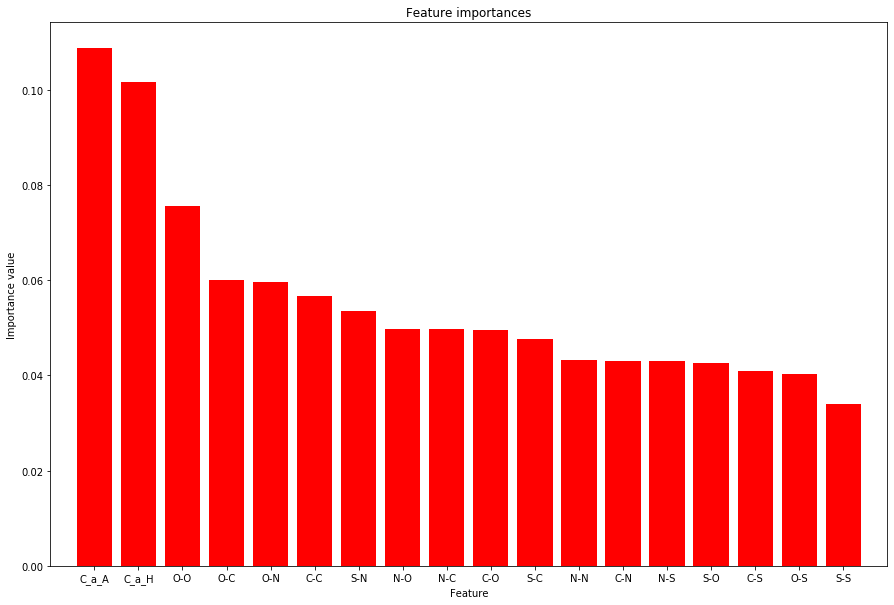

In [72]:
'''
features based on combination of:
atom_types = ['C','N','O,'S']
'''

atom_types = ['C','N','O','S']
feature_labels = []
for i in range(len(atom_types)):
    for j in range(len(atom_types)):
        label = atom_types[i]+'-'+atom_types[j]
        feature_labels.append(label)
feature_labels+=['C_a_H', 'C_a_A']
feature_labels=np.array(feature_labels)

importance = rf.feature_importances_

#indices = np.argsort(importance)[::-1][:20]
indices = np.argsort(importance)[::-1]

print("Top Feature ranking:")
n = importance.shape[0]
#n = 20
for f in range(n):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importance[indices[f]]))


plt.figure()
plt.title("Feature importances")
plt.bar(range(n), importance[indices],
       color="r", align="center")
plt.xticks(range(n), feature_labels[indices])
plt.xlim([-1, n])
plt.xlabel('Feature')
plt.ylabel('Importance value')
plt.show()

In [37]:
'''
permutation importance on train data
'''
result = permutation_importance(rf, x_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=-1)

sorted_idx = result.importances_mean.argsort()
p_importance_mean_train = result.importances_mean
print(p_importance_mean_train)
print(sorted_idx)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.1s finished


[0.11673993 0.06239268 0.10561461 0.06061745 0.10864211 0.06283129
 0.0975277  0.08867516 0.13241765 0.1496225  0.20302726 0.05719417
 0.07636657 0.18162455 0.06540092 0.08135953 0.26463167 0.56598616]
[11  3  1  5 14 12 15  7  6  2  4  0  8  9 13 10 16 17]


In [38]:
'''
permutation importance on test data
'''
result = permutation_importance(rf, x_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=-1)

sorted_idx = result.importances_mean.argsort()
p_importance_mean_test = result.importances_mean
print(p_importance_mean_test)
print(sorted_idx)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished


[ 0.02725345  0.01000416  0.00760272  0.0068398   0.02740422  0.00322749
  0.00595238  0.00261261  0.02004775  0.03816556  0.03529331  0.00086465
  0.00655367  0.04478114 -0.00309697  0.03492419  0.05808484  0.19752509]
[14 11  7  5  6 12  3  2  1  8  0  4 15 10  9 13 16 17]


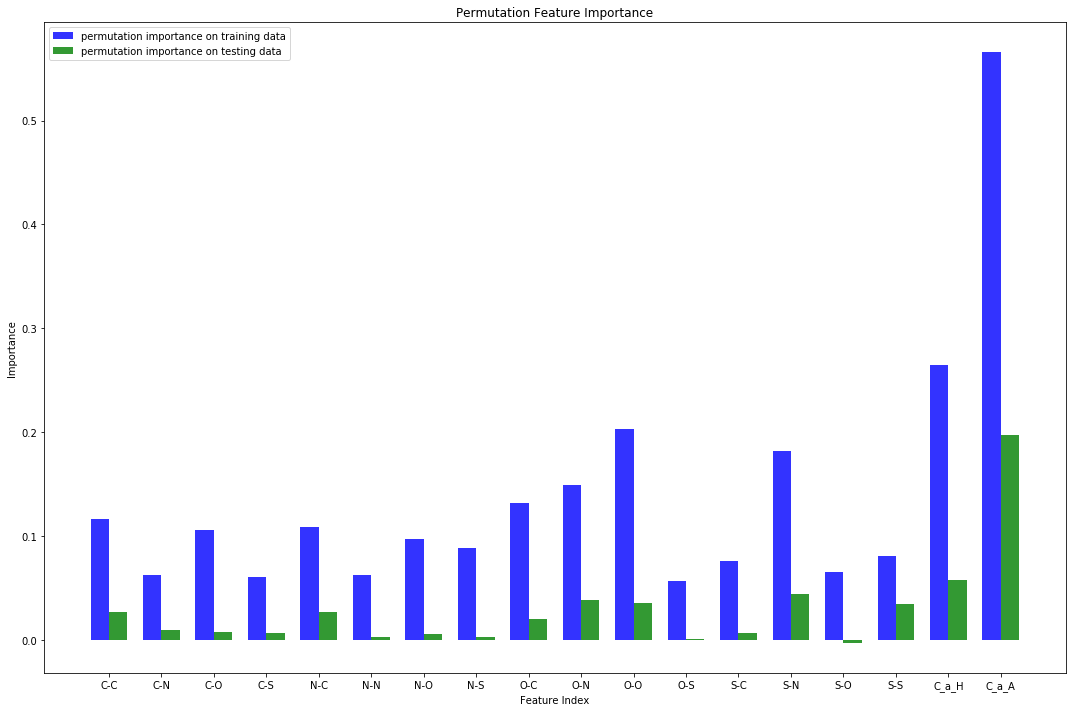

In [41]:
# data to plot
length = len(p_importance_mean_test)


# create plot
fig, ax = plt.subplots()
index = np.arange(length)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index - bar_width/2, p_importance_mean_train, bar_width,
alpha=opacity,
color='b',
label='permutation importance on training data')

rects2 = plt.bar(index + bar_width/2, p_importance_mean_test, bar_width,
alpha=opacity,
color='g',
label='permutation importance on testing data')

plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Permutation Feature Importance')
plt.xticks(np.arange(0,length), feature_labels)
plt.legend()

plt.tight_layout()
plt.show()

#### 4 Angstrom cutoff

In [74]:
data_file = os.getcwd()+'/Data/dataset_ha_beta_4A.pkl'
dataset = dataset_loader(data_file)

features = np.array([data['x_vector'] for data in dataset])
labels = np.array([data['y'] for data in dataset])
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=13)
print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (1812, 18)
Training Labels Shape: (1812,)
Testing Features Shape: (604, 18)
Testing Labels Shape: (604,)


In [75]:
'''Model Loader'''
model_file= os.getcwd()+"/Model/rf_pp_ha_beta_4A_split.pkl"
with open(model_file, "rb") as f:
    rf = pickle.load(f)

C:\Users\beryl\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\beryl\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [76]:
'''Model evaluation on Test set'''
#Mean Absolute Error
preds = rf.predict(x_test)
errors = abs(preds - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2))

#Mean Absolute Percentage Error & Accuracy
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

#Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, preds))
print('Root Mean Squared Error :', round(rmse, 2))

#Pearson Correlation Coefficient (PCC) score
pcc = pearsonr(y_test, preds)
print('Pearson Correlation Coefficient :', round(pcc[0],2))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished


Mean Absolute Error: 1.43
Accuracy: 77.07 %.
Root Mean Squared Error : 1.87
Pearson Correlation Coefficient : 0.35


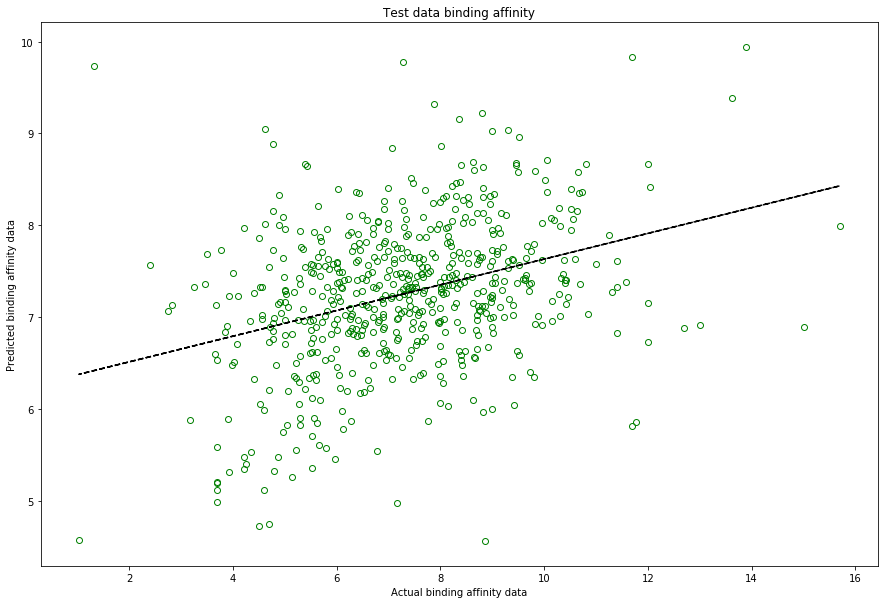

In [77]:
import matplotlib.pyplot as plt

fig_size = np.zeros(2)
fig_size[0] = 15
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

f, ax = plt.subplots()

plt.plot(y_test, preds, 'o', markerfacecolor="None", markeredgecolor='green', markeredgewidth=1)
#ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
coef = np.polyfit(y_test,preds,1)
poly1d_fn = np.poly1d(coef)
plt.plot(y_test, poly1d_fn(y_test), '--k')

plt.title("Test data binding affinity")
plt.xlabel('Actual binding affinity data')
plt.ylabel('Predicted binding affinity data')
#plt.legend()
plt.show()

Top Feature ranking:
1. feature 0 (0.111758)
2. feature 2 (0.103460)
3. feature 8 (0.102103)
4. feature 4 (0.096238)
5. feature 9 (0.088906)
6. feature 6 (0.083047)
7. feature 10 (0.077822)
8. feature 1 (0.077635)
9. feature 5 (0.060353)
10. feature 12 (0.042364)
11. feature 3 (0.041709)
12. feature 13 (0.026116)
13. feature 14 (0.023586)
14. feature 7 (0.021648)
15. feature 11 (0.019878)
16. feature 15 (0.017996)
17. feature 16 (0.002876)
18. feature 17 (0.002505)


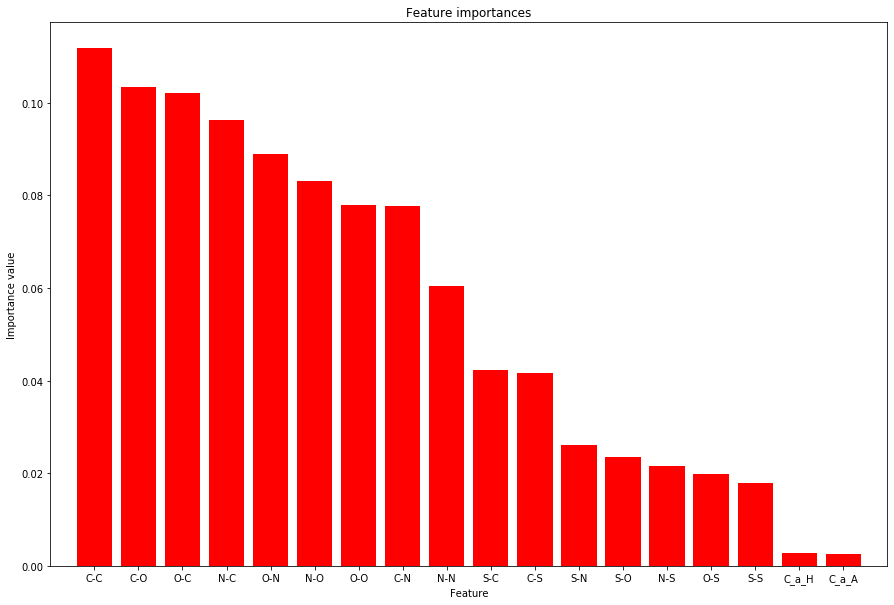

In [78]:
'''
features based on combination of:
atom_types = ['C','N','O,'S']
'''

atom_types = ['C','N','O','S']
feature_labels = []
for i in range(len(atom_types)):
    for j in range(len(atom_types)):
        label = atom_types[i]+'-'+atom_types[j]
        feature_labels.append(label)
feature_labels+=['C_a_H', 'C_a_A']
feature_labels=np.array(feature_labels)

importance = rf.feature_importances_

#indices = np.argsort(importance)[::-1][:20]
indices = np.argsort(importance)[::-1]

print("Top Feature ranking:")
n = importance.shape[0]
#n = 20
for f in range(n):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importance[indices[f]]))


plt.figure()
plt.title("Feature importances")
plt.bar(range(n), importance[indices],
       color="r", align="center")
plt.xticks(range(n), feature_labels[indices])
plt.xlim([-1, n])
plt.xlabel('Feature')
plt.ylabel('Importance value')
plt.show()

#### 8 Angstrom cutoff

In [79]:
data_file = os.getcwd()+'/Data/dataset_ha_beta_8A.pkl'
dataset = dataset_loader(data_file)

features = np.array([data['x_vector'] for data in dataset])
labels = np.array([data['y'] for data in dataset])
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=13)
print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (1812, 18)
Training Labels Shape: (1812,)
Testing Features Shape: (604, 18)
Testing Labels Shape: (604,)


In [80]:
'''Model Loader'''
model_file= os.getcwd()+"/Model/rf_pp_ha_beta_8A_split.pkl"
with open(model_file, "rb") as f:
    rf = pickle.load(f)

C:\Users\beryl\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\beryl\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [81]:
'''Model evaluation on Test set'''
#Mean Absolute Error
preds = rf.predict(x_test)
errors = abs(preds - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2))

#Mean Absolute Percentage Error & Accuracy
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

#Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, preds))
print('Root Mean Squared Error :', round(rmse, 2))

#Pearson Correlation Coefficient (PCC) score
pcc = pearsonr(y_test, preds)
print('Pearson Correlation Coefficient :', round(pcc[0],2))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished


Mean Absolute Error: 1.39
Accuracy: 77.99 %.
Root Mean Squared Error : 1.81
Pearson Correlation Coefficient : 0.42


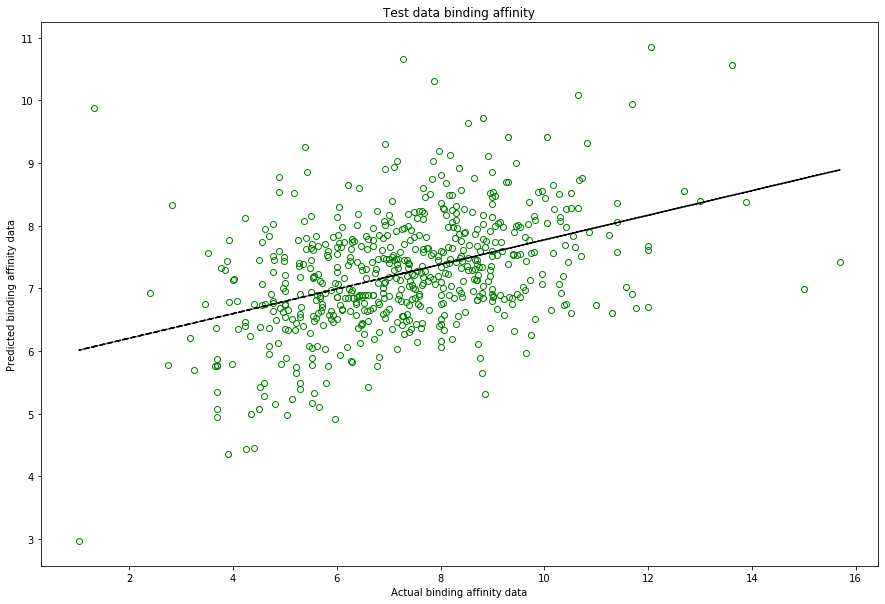

In [82]:
import matplotlib.pyplot as plt

fig_size = np.zeros(2)
fig_size[0] = 15
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

f, ax = plt.subplots()

plt.plot(y_test, preds, 'o', markerfacecolor="None", markeredgecolor='green', markeredgewidth=1)
#ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
coef = np.polyfit(y_test,preds,1)
poly1d_fn = np.poly1d(coef)
plt.plot(y_test, poly1d_fn(y_test), '--k')

plt.title("Test data binding affinity")
plt.xlabel('Actual binding affinity data')
plt.ylabel('Predicted binding affinity data')
#plt.legend()
plt.show()

Top Feature ranking:
1. feature 16 (0.080201)
2. feature 8 (0.073643)
3. feature 0 (0.069616)
4. feature 17 (0.067297)
5. feature 9 (0.063912)
6. feature 4 (0.063104)
7. feature 2 (0.059922)
8. feature 6 (0.058220)
9. feature 10 (0.057627)
10. feature 14 (0.057096)
11. feature 1 (0.054647)
12. feature 12 (0.053135)
13. feature 5 (0.051490)
14. feature 13 (0.050674)
15. feature 3 (0.044765)
16. feature 11 (0.037767)
17. feature 7 (0.037497)
18. feature 15 (0.019388)


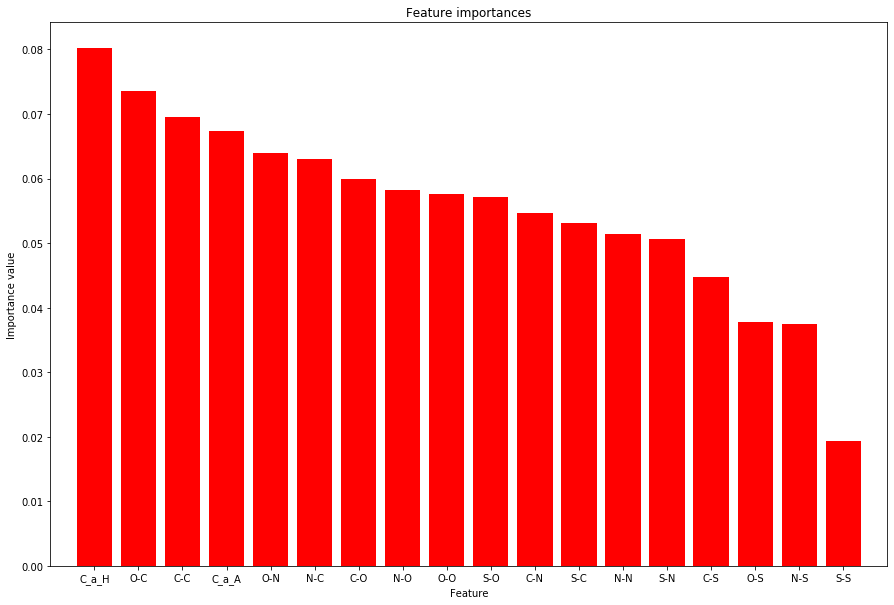

In [83]:
'''
features based on combination of:
atom_types = ['C','N','O,'S']
'''

atom_types = ['C','N','O','S']
feature_labels = []
for i in range(len(atom_types)):
    for j in range(len(atom_types)):
        label = atom_types[i]+'-'+atom_types[j]
        feature_labels.append(label)
feature_labels+=['C_a_H', 'C_a_A']
feature_labels=np.array(feature_labels)

importance = rf.feature_importances_

#indices = np.argsort(importance)[::-1][:20]
indices = np.argsort(importance)[::-1]

print("Top Feature ranking:")
n = importance.shape[0]
#n = 20
for f in range(n):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importance[indices[f]]))


plt.figure()
plt.title("Feature importances")
plt.bar(range(n), importance[indices],
       color="r", align="center")
plt.xticks(range(n), feature_labels[indices])
plt.xlim([-1, n])
plt.xlabel('Feature')
plt.ylabel('Importance value')
plt.show()

##### 16 Angstrom cutoff

In [84]:
data_file = os.getcwd()+'/Data/dataset_ha_beta_16A.pkl'
dataset = dataset_loader(data_file)

features = np.array([data['x_vector'] for data in dataset])
labels = np.array([data['y'] for data in dataset])
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=13)
print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (1812, 18)
Training Labels Shape: (1812,)
Testing Features Shape: (604, 18)
Testing Labels Shape: (604,)


In [88]:
'''Model Loader'''
model_file= os.getcwd()+"/Model/rf_pp_ha_beta_16A_split.pkl"
with open(model_file, "rb") as f:
    rf = pickle.load(f)

In [89]:
'''Model evaluation on Test set'''
#Mean Absolute Error
preds = rf.predict(x_test)
errors = abs(preds - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2))

#Mean Absolute Percentage Error & Accuracy
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

#Root Mean Squared Error
rmse = sqrt(mean_squared_error(y_test, preds))
print('Root Mean Squared Error :', round(rmse, 2))

#Pearson Correlation Coefficient (PCC) score
pcc = pearsonr(y_test, preds)
print('Pearson Correlation Coefficient :', round(pcc[0],2))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished


Mean Absolute Error: 1.37
Accuracy: 78.16 %.
Root Mean Squared Error : 1.76
Pearson Correlation Coefficient : 0.46


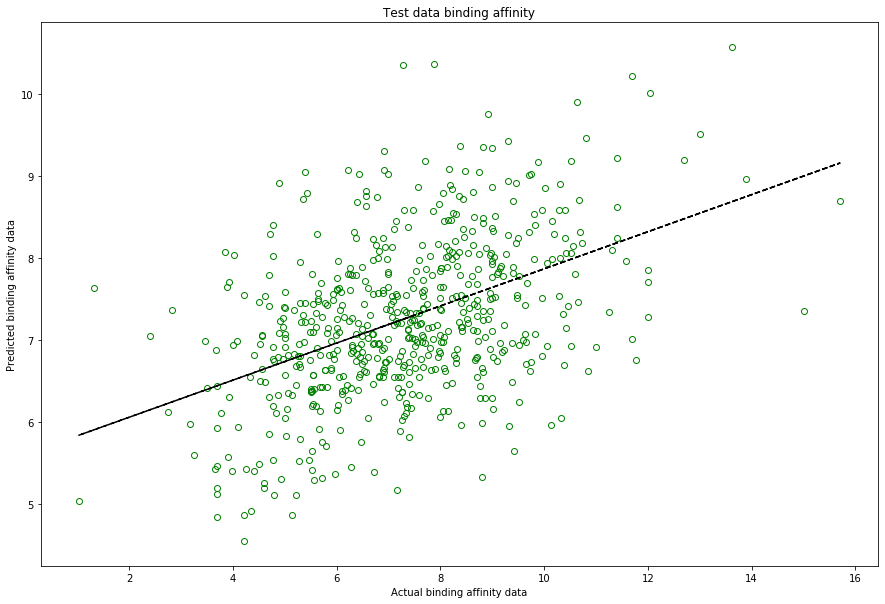

In [90]:
import matplotlib.pyplot as plt

fig_size = np.zeros(2)
fig_size[0] = 15
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

f, ax = plt.subplots()

plt.plot(y_test, preds, 'o', markerfacecolor="None", markeredgecolor='green', markeredgewidth=1)
#ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
coef = np.polyfit(y_test,preds,1)
poly1d_fn = np.poly1d(coef)
plt.plot(y_test, poly1d_fn(y_test), '--k')

plt.title("Test data binding affinity")
plt.xlabel('Actual binding affinity data')
plt.ylabel('Predicted binding affinity data')
#plt.legend()
plt.show()

Top Feature ranking:
1. feature 17 (0.133003)
2. feature 16 (0.092227)
3. feature 10 (0.075436)
4. feature 9 (0.056581)
5. feature 14 (0.050453)
6. feature 2 (0.050185)
7. feature 11 (0.049568)
8. feature 12 (0.048493)
9. feature 15 (0.047658)
10. feature 0 (0.047536)
11. feature 1 (0.047291)
12. feature 8 (0.045693)
13. feature 5 (0.045661)
14. feature 13 (0.045379)
15. feature 6 (0.043925)
16. feature 3 (0.040830)
17. feature 7 (0.040780)
18. feature 4 (0.039300)


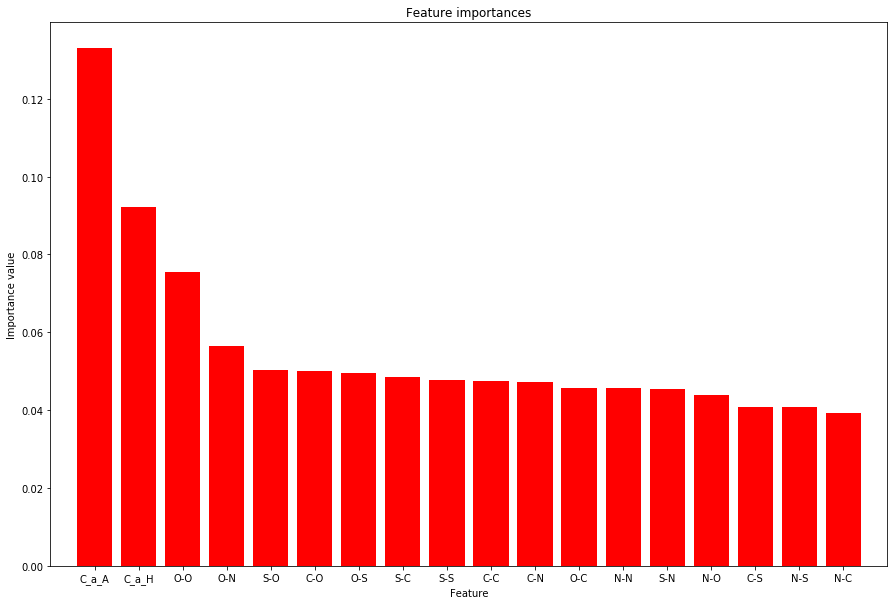

In [91]:
'''
features based on combination of:
atom_types = ['C','N','O,'S']
'''

atom_types = ['C','N','O','S']
feature_labels = []
for i in range(len(atom_types)):
    for j in range(len(atom_types)):
        label = atom_types[i]+'-'+atom_types[j]
        feature_labels.append(label)
feature_labels+=['C_a_H', 'C_a_A']
feature_labels=np.array(feature_labels)

importance = rf.feature_importances_

#indices = np.argsort(importance)[::-1][:20]
indices = np.argsort(importance)[::-1]

print("Top Feature ranking:")
n = importance.shape[0]
#n = 20
for f in range(n):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importance[indices[f]]))


plt.figure()
plt.title("Feature importances")
plt.bar(range(n), importance[indices],
       color="r", align="center")
plt.xticks(range(n), feature_labels[indices])
plt.xlim([-1, n])
plt.xlabel('Feature')
plt.ylabel('Importance value')
plt.show()

In [96]:
'''
permutation importance on test data
'''
result = permutation_importance(rf, x_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=-1)

sorted_idx = result.importances_mean.argsort()[::-1]
p_importance_mean_test = result.importances_mean
print(p_importance_mean_test)
print(sorted_idx)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished


[0.02534273 0.01981853 0.01173228 0.00944142 0.00585488 0.00804027
 0.00968839 0.00587544 0.00647286 0.04778359 0.0448579  0.03421148
 0.01340655 0.01570419 0.02341884 0.01592081 0.1742104  0.2088501 ]
[17 16  9 10 11  0 14  1 15 13 12  2  6  3  5  8  7  4]


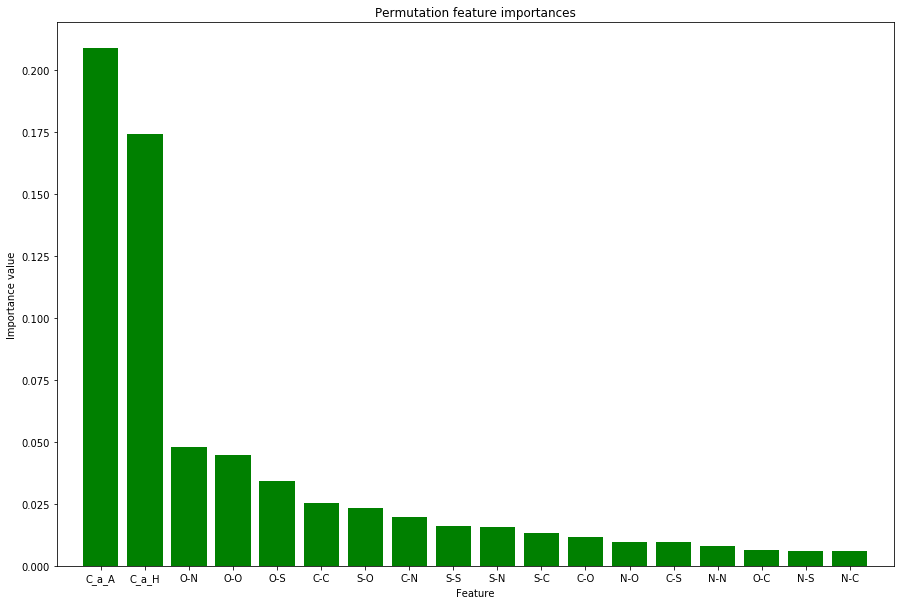

In [104]:
# data to plot
length = len(sorted_idx)

atom_types = ['C','N','O','S']
feature_labels = []
for i in range(len(atom_types)):
    for j in range(len(atom_types)):
        label = atom_types[i]+'-'+atom_types[j]
        feature_labels.append(label)
feature_labels+=['C_a_H', 'C_a_A']
feature_labels=np.array(feature_labels)
indices = sorted_idx
# create plot

plt.figure()
plt.title("Permutation feature importances")
plt.bar(range(length), p_importance_mean_test[indices],
       color="g", align="center")
plt.xticks(range(length), feature_labels[indices])
plt.xlim([-1, length])
plt.xlabel('Feature')
plt.ylabel('Importance value')
plt.show()

### Comparison of R and feature importance

In [106]:
'''data values'''
cutoffs = np.array([4,8,12,16])
PCC_R = np.array([0.35, 0.42, 0.43, 0.46])
feature_importances = np.zeros((4, 18))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [108]:
'''model loader to get the feature importance values'''
rfs = []
for cutoff in cutoffs:
    with open(os.getcwd()+"/Model/rf_pp_ha_beta_"+str(cutoff)+"A_split.pkl", "rb") as f:
        rfs.append(pickle.load(f))

C:\Users\beryl\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\beryl\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [109]:
'''fill the feature_importances'''
for idx, rf in enumerate(rfs):
    feature_importances[idx]=rf.feature_importances_
print(feature_importances)

[[0.11175806 0.07763539 0.10346004 0.04170897 0.09623754 0.0603526
  0.08304709 0.02164767 0.10210291 0.08890647 0.07782158 0.01987789
  0.04236383 0.02611647 0.02358577 0.01799616 0.00287621 0.00250534]
 [0.06961555 0.05464723 0.05992185 0.04476529 0.06310407 0.05148989
  0.05822023 0.03749711 0.07364296 0.06391224 0.05762686 0.03776707
  0.05313479 0.05067361 0.05709618 0.01938788 0.08020055 0.06729665]
 [0.05662473 0.04310486 0.04960245 0.04103954 0.04982183 0.04319387
  0.0498449  0.04300576 0.06010076 0.05972551 0.07552061 0.04024279
  0.04765858 0.05356842 0.04251898 0.03396121 0.10170944 0.10875577]
 [0.04753566 0.04729072 0.0501853  0.04083004 0.0393004  0.04566095
  0.04392532 0.04078007 0.04569337 0.05658063 0.07543642 0.04956777
  0.04849293 0.04537927 0.05045304 0.04765827 0.09222696 0.13300286]]


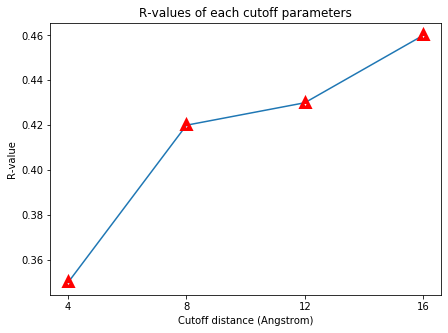

In [117]:
'''R comparison'''
fig_size = np.zeros(2)
fig_size[0] = 7
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
plt.plot(cutoffs, PCC_R, '^-', markerfacecolor="None", markeredgecolor='red', markeredgewidth=5)
plt.rcParams["figure.figsize"] = fig_size
plt.title("R-values of each cutoff parameters")
plt.xlabel('Cutoff distance (Angstrom)')
plt.ylabel('R-value')
plt.xticks(cutoffs)
#plt.legend()
plt.show()

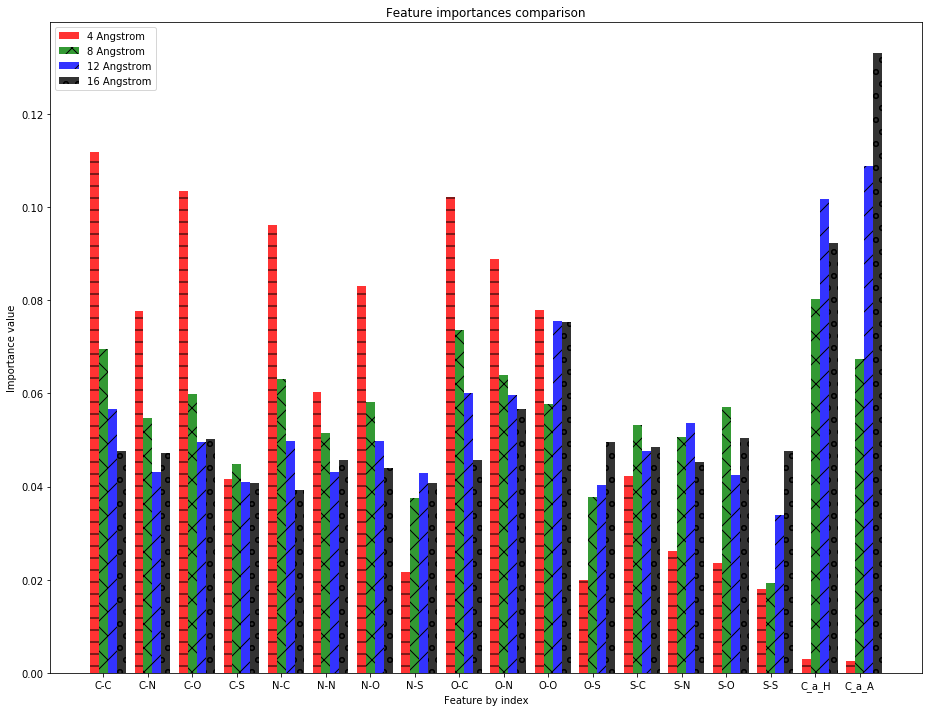

In [152]:
'''feature importance comparisons'''
# data to plot
n_groups = feature_importances[0].shape[0]

# create plot
fig_size = np.zeros(2)
fig_size[0] = 13
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.8
opacity = 0.8

rects1 = plt.bar(index - bar_width/4, feature_importances[0], bar_width/4,
alpha=opacity,
color='r', hatch='-',
label='4 Angstrom')

rects2 = plt.bar(index, feature_importances[1], bar_width/4,
alpha=opacity,
color='g',hatch='x',
label='8 Angstrom')

rects2 = plt.bar(index + bar_width/4, feature_importances[2], bar_width/4,
alpha=opacity,
color='b',hatch='/',
label='12 Angstrom')

rects2 = plt.bar(index + 2*bar_width/4, feature_importances[3], bar_width/4,
alpha=opacity,
color='black',hatch='o',
label='16 Angstrom')

plt.xlabel('Feature by index')
plt.ylabel('Importance value')
plt.title('Feature importances comparison')
plt.xticks(index, feature_labels)
plt.legend()

plt.tight_layout()
plt.show()

### Cross Fold Validation

In [29]:
'''K-Fold model evaluation'''
folds = [3,4,5,7,10]
kfolds=[]
for fold in folds:
    #with open(os.getcwd()+"/Model/rf_pp_a_"+str(fold)+"fold_best.pkl", "rb") as f:
    with open(os.getcwd()+"/Model/cfold/rf_pp_ha_a_"+str(fold)+"fold_best.pkl", "rb") as f:
        kfolds.append(pickle.load(f))

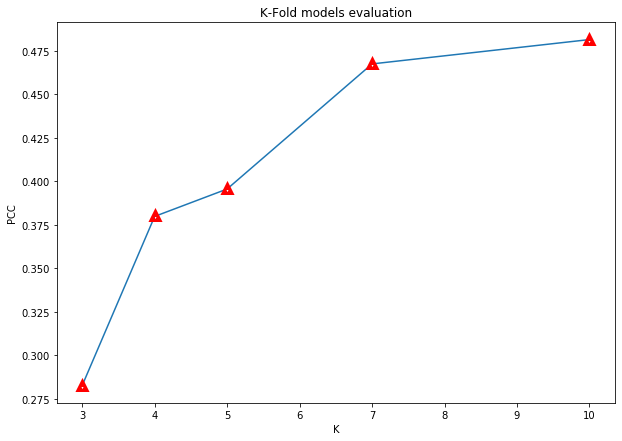

In [30]:
ks = np.array([kfold["k"] for kfold in kfolds])
pcc_tests = np.array([kfold["pcc_test"] for kfold in kfolds])
pcc_trains = np.array([kfold["pcc_train"] for kfold in kfolds])

fig_size = np.zeros(2)
fig_size[0] = 10
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size
plt.plot(ks, pcc_tests, '^-', markerfacecolor="None", markeredgecolor='red', markeredgewidth=5)
plt.title("K-Fold models evaluation")
plt.xlabel('K')
plt.ylabel('PCC')
#plt.legend()
plt.show()

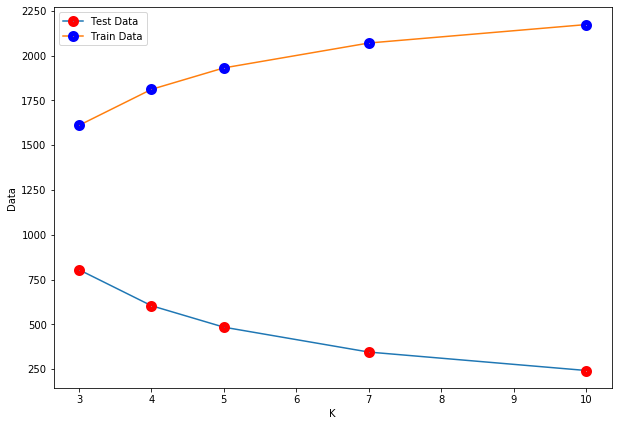

In [31]:
total_train_data = np.array([kfold["train_idx"].shape[0] for kfold in kfolds])
total_test_data = np.array([kfold["test_idx"].shape[0] for kfold in kfolds])
plt.plot(ks, total_test_data,'o-', markerfacecolor="None", markeredgecolor='red', markeredgewidth=5, label="Test Data")
plt.plot(ks, total_train_data,'o-', markerfacecolor="None", markeredgecolor='blue', markeredgewidth=5, label="Train Data")
plt.xlabel("K")
plt.ylabel("Data")
plt.legend()
plt.show()

### Inference on various complexes

In [33]:
'''Full-data model load'''
def data_load(filename):
    '''
    data checker
    '''
    data = []
    try:
        with open(filename, 'rb') as fr:
            try:
                while True:
                    data.append(pickle.load(fr))
            except EOFError:
                pass            
    except FileNotFoundError:
        print('File is not found')
    return data

full_model = os.getcwd()+"/Model/rf_pp_ha_alpha_full.pkl"
with open(full_model, "rb") as f:
    rf = pickle.load(f)

### Inference on PC-PC

In [34]:
path = os.getcwd()+"/Data/data_PC-PC.pkl"
data =data_load(path)
ids = [d["id"] for d in data]
vectors = [d["x_vector"] for d in data]
temp = ids[1]
del ids[1]
ids.append(temp)
temp = vectors[1]
del vectors[1]
vectors.append(temp)
pred_PCPC = rf.predict(vectors)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished


### Inference on PC-CytF

In [35]:
path = os.getcwd()+"/Data/data_PC-CF.pkl"
data =data_load(path)
ids = [d["id"] for d in data]
vectors = [d["x_vector"] for d in data]
temp = ids[1]
del ids[1]
ids.append(temp)
temp = vectors[1]
del vectors[1]
vectors.append(temp)
pred_PCCF = rf.predict(vectors)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished


### Inference on PC-CytF experimental structure

In [36]:
path = os.getcwd()+"/Data/data_PC-CF_exp.pkl"
data =data_load(path)
ids = [d["id"] for d in data]
vectors = [d["x_vector"] for d in data]
pred_PCCF_exp = rf.predict(vectors)
print(pred_PCCF_exp)
print(ids)

[6.82370286 7.34691624 7.50137857]
['1tkw.pdb', '2jxm.pdb', '2pcf.pdb']


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished


### Inference on 4azu

In [37]:
path = os.getcwd()+"/Data/data_4azu.pkl"
data =data_load(path)
vectors = [d["x_vector"] for d in data]
pred_4azu = rf.predict(vectors)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1000 out of 1000 | elapsed:    0.0s finished


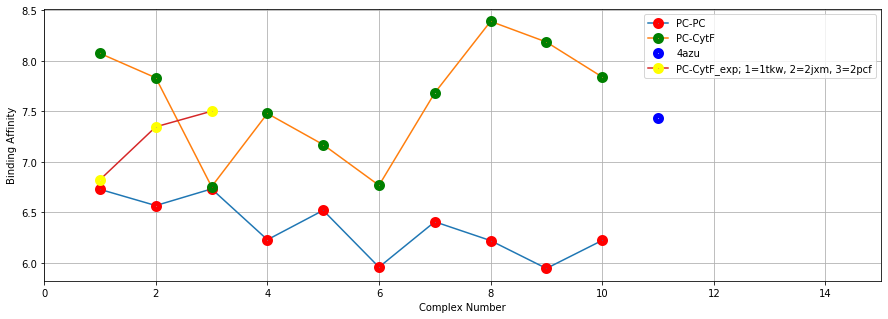

In [39]:
import matplotlib.pyplot as plt
length = 10
idx = np.linspace(1, length, length)
fig_size = np.zeros(2)
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
plt.xlim([0,15])
plt.plot(idx, pred_PCPC,'o-', markerfacecolor="None", markeredgecolor='red', markeredgewidth=5, label="PC-PC" )
plt.plot(idx, pred_PCCF,'o-', markerfacecolor="None", markeredgecolor='green', markeredgewidth=5, label="PC-CytF")
plt.plot(11, pred_4azu,'o', markerfacecolor="None", markeredgecolor='blue', markeredgewidth=5, label="4azu")
plt.plot(np.linspace(1, 3, 3), pred_PCCF_exp,'o-', markerfacecolor="None", markeredgecolor='yellow', markeredgewidth=5, label="PC-CytF_exp; 1=1tkw, 2=2jxm, 3=2pcf")
plt.xlabel("Complex Number")
plt.ylabel("Binding Affinity")
plt.legend()
plt.grid(True)
plt.show()